<h1 align="center">Data Batching Example in TensorFlow</h1>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd 
import numpy as np
import seaborn as sns

In [2]:
iris_df = sns.load_dataset('iris')
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
labels = pd.Categorical(iris_df.species).codes.astype(np.int32)

In [4]:
data = iris_df.drop('species', axis=1).values

In [7]:
import tensorflow as tf
from tqdm import tqdm

250it [00:20,  4.06it/s]

  2%|▊                                          | 1/50 [00:00<00:24,  1.99it/s]

Processed 50 batches
Processed 100 batches


100it [00:00,  2.85it/s]                                                       

Processed 150 batches


183it [00:00,  4.06it/s]

Processed 200 batches
Processed 250 batches


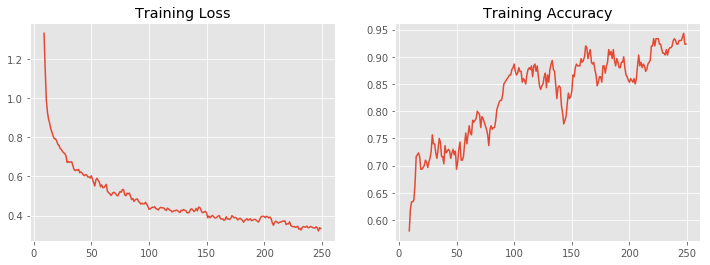

In [6]:
tf.reset_default_graph()

n_epochs = 50
batch_size = 30

dataset = tf.data.Dataset.from_tensor_slices((data, labels))
dataset = dataset.shuffle(buffer_size=128).repeat(n_epochs).batch(batch_size)
data_iter = dataset.make_one_shot_iterator()
x_in, y_in = data_iter.get_next()

one_hot = tf.one_hot(y_in, depth=3)

net = tf.layers.dense(
    inputs=x_in,
    units=3,
    activation=None,   
    name='dense_1'    
)

predictions = tf.argmax(net, axis=1)
true_label_idx = tf.argmax(one_hot, axis=1)

train_accuracy = tf.reduce_mean(
    tf.cast(
        tf.equal(predictions, true_label_idx), 
        dtype=tf.float32
    )
)
                                
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot, logits=net, name='loss'))
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)

losses = []
accuracies = []

pbar = tqdm(total=n_epochs)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    idx = 0
    
    while True:
        try:
            _, loss_val, acc = session.run([train_op, loss, train_accuracy])
            
            losses.append(loss_val)
            accuracies.append(acc)
            idx += 1            
            if idx % 50 == 0:
                print("Processed {} batches".format(idx)) 
            
            pbar.update(1)
            
        except tf.errors.OutOfRangeError:
            break
    
losses = pd.Series(losses)
accuracies = pd.Series(accuracies)

_, ax = plt.subplots(1, 2, figsize=(12, 4))

ax_0 = losses.rolling(10).mean().plot(title='Training Loss', ax=ax[0])
ax_1 = accuracies.rolling(10).mean().plot(title='Training Accuracy', ax=ax[1])